In [1]:
# from pandas_datareader import data
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import warnings
warnings.filterwarnings('ignore')

Случаи заражения

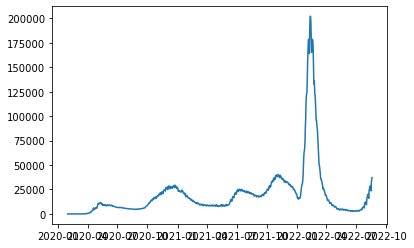

In [21]:
aapl = pd.read_csv('owid-covid-data.csv', sep = ',', parse_dates=True, index_col = 'date')
series1 = aapl.query('location == "Russia"')['new_cases'].sort_index()['2020-01':'2022-08']#original series

idx = pd.date_range(start="2020-01-31",end="2022-08-19")
series1 = pd.Series(index = idx, data = series1)

ax = plt.axes()
# ax.set_facecolor('beige')
plt.plot(series1);

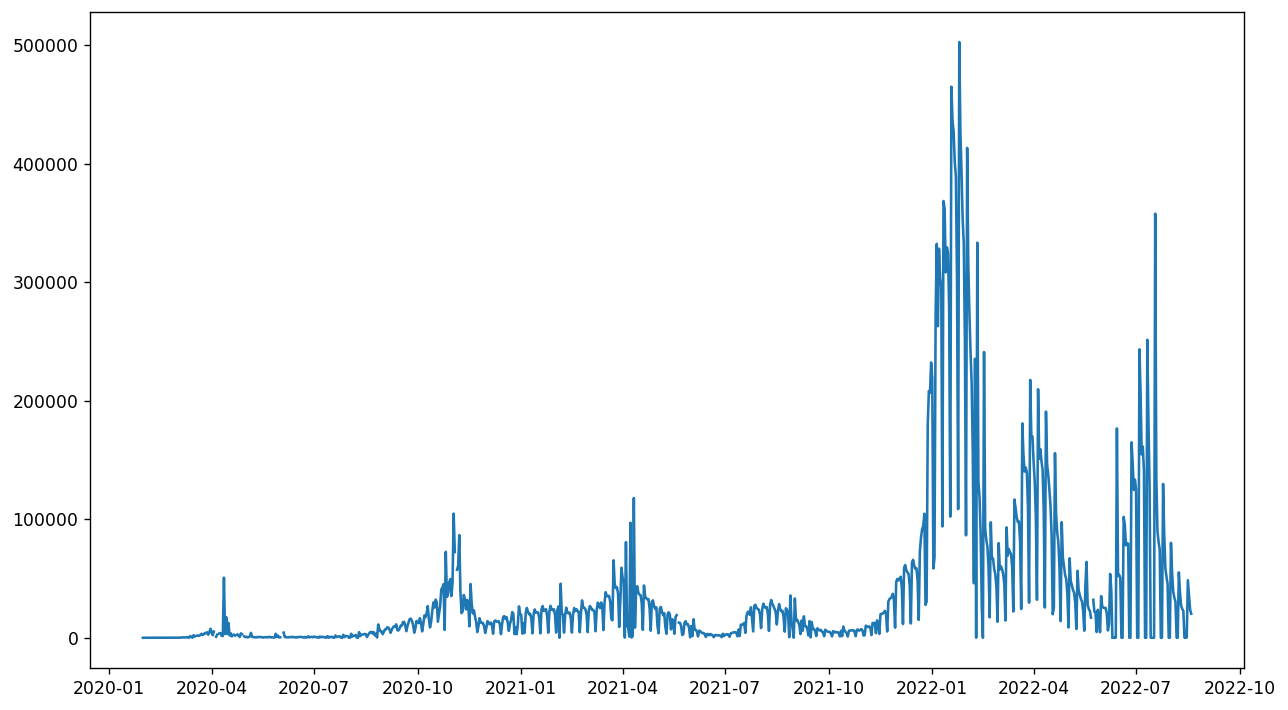

In [147]:
seriesl = aapl.query('location == "France"')['new_cases'].sort_index()['2020-01':'2022-08']#original series

idxl = pd.date_range(start="2020-01-31",end="2022-08-19")
seriesl = pd.Series(index = idxl, data = seriesl)

ax = plt.axes()
# ax.set_facecolor('beige')
plt.plot(seriesl);

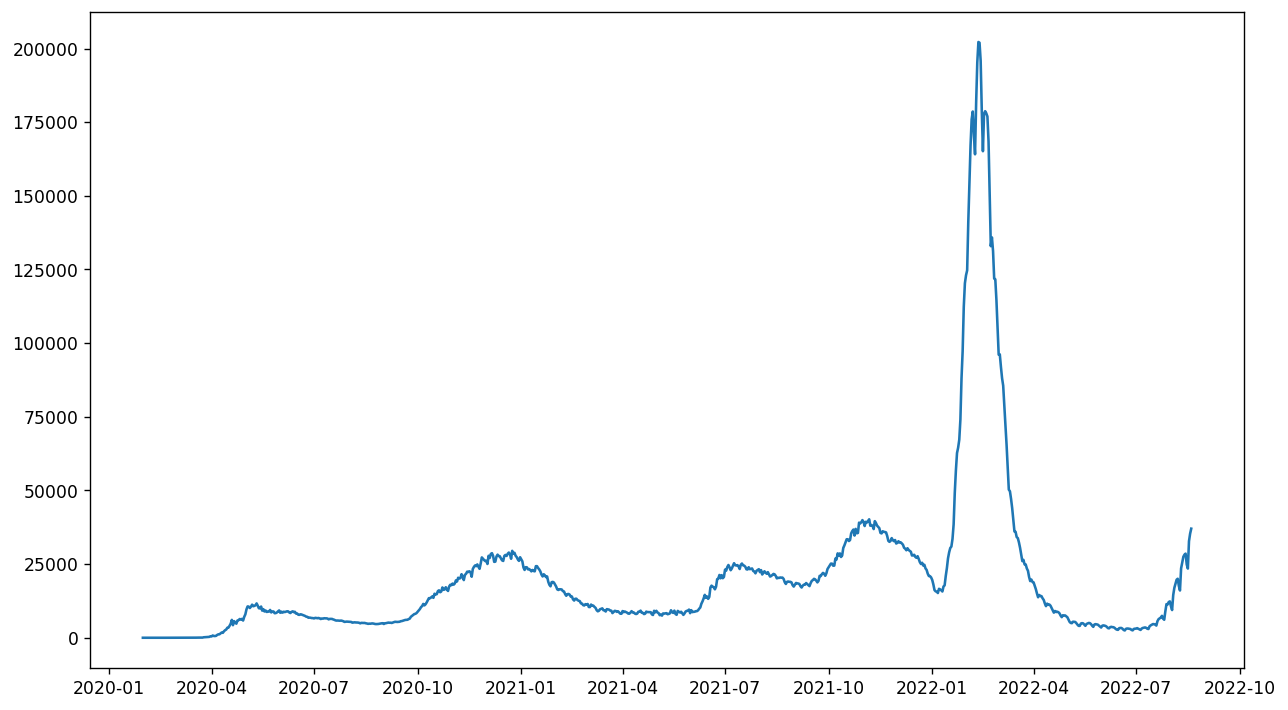

In [138]:
ax = plt.axes()

plt.plot(series1);

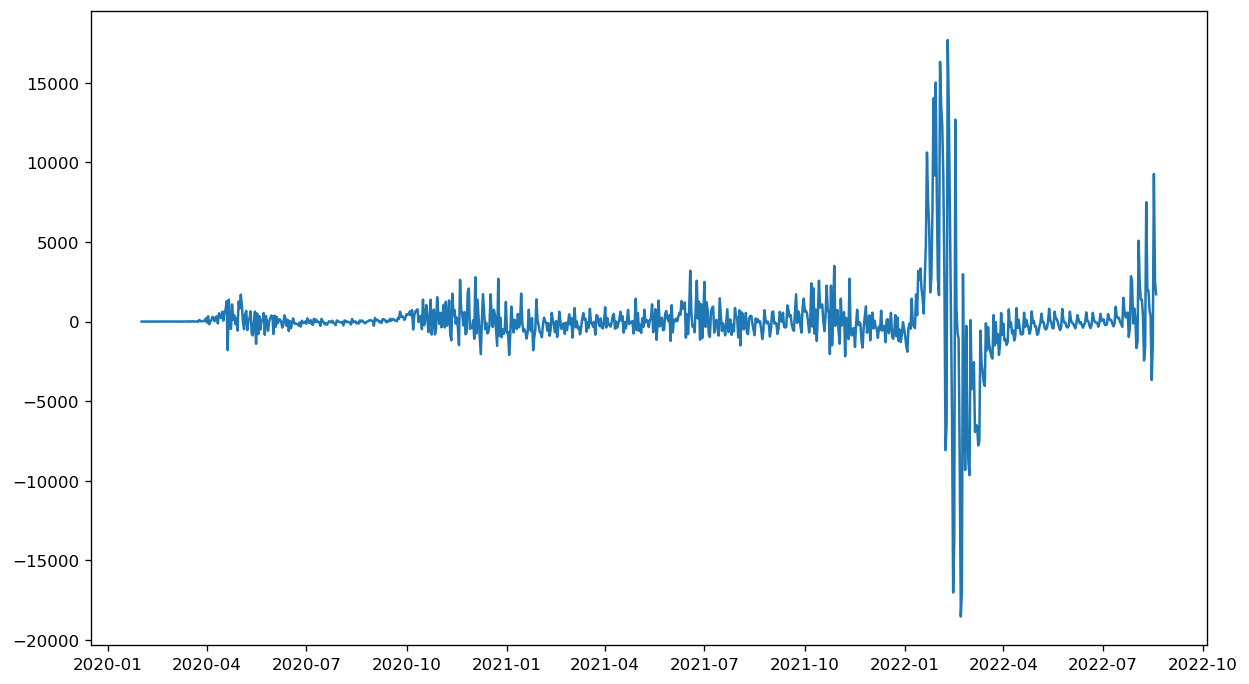

In [42]:
ax = plt.axes()
series2 = series1.sort_index().diff(1).dropna() #first order differenced series
# ax.set_facecolor('silver')
plt.plot(series2);

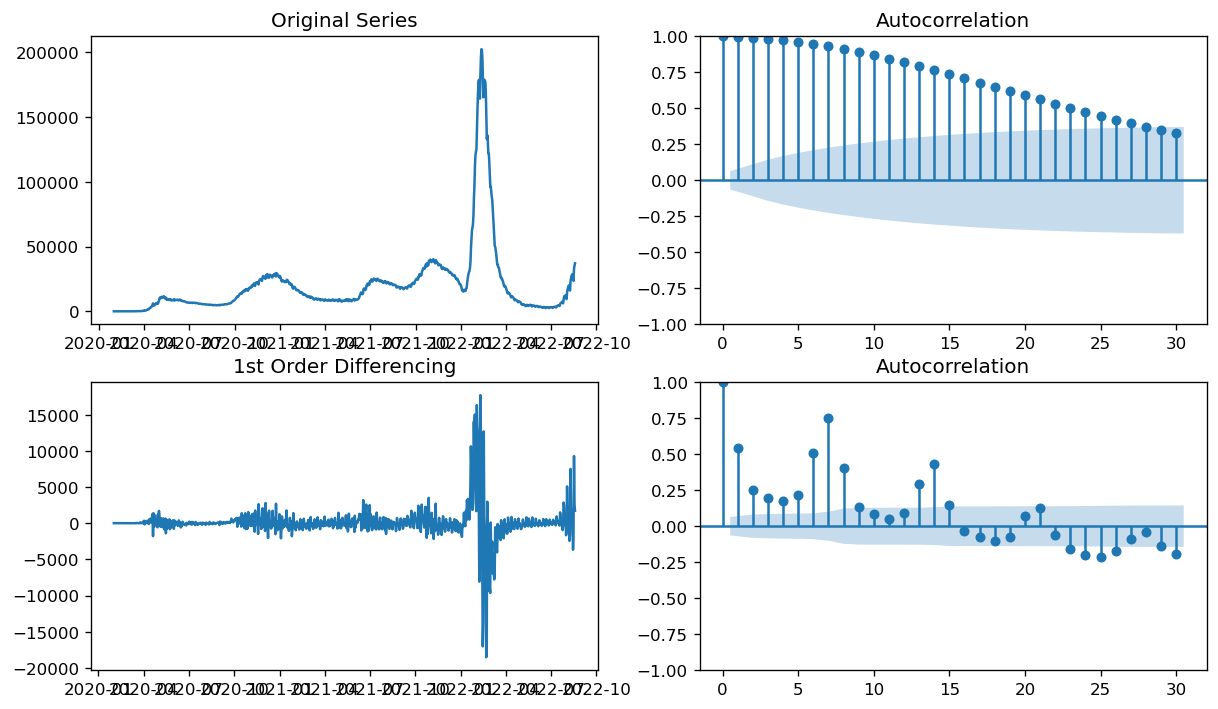

In [43]:
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(series1); 
axes[0, 0].set_title('Original Series')
plot_acf(series1, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(series2);
axes[1, 0].set_title('1st Order Differencing')
plot_acf(series2, ax=axes[1, 1])
plt.show()

In [49]:
# Adf Test
ndiffs(series2, test='adf') # output is 0
# KPSS test
ndiffs(series2, test='kpss')  # output is 0
# PP test:
ndiffs(series2, test='pp')  # output is 0

0

In [50]:
import statsmodels.tsa.stattools as ts

ts.adfuller(series2) # т.к. t-статистика < 2, то гипотеза о наличии единичного корня не отвергается, т.е. d=0


(-7.701841330394517,
 1.3329170132471676e-11,
 15,
 915,
 {'1%': -3.437516929214992,
  '5%': -2.86470390726455,
  '10%': -2.5684546666069457},
 15559.0289441727)

In [51]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(series2, order=(14,1,6)) # 0.5>0.05 => гипотеза об автокоррелированности остатков отвергается :)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  931
Model:                ARIMA(14, 1, 6)   Log Likelihood               -7938.966
Date:                Sat, 20 Aug 2022   AIC                          15919.932
Time:                        22:22:12   BIC                          16021.470
Sample:                    02-01-2020   HQIC                         15958.659
                         - 08-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0817      0.053     -1.543      0.123      -0.185       0.022
ar.L2          0.8355      0.046     18.355      0.000       0.746       0.925
ar.L3         -0.7250      0.060    -12.162      0.0

In [52]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(series1, order=(14,1,6)).fit() # гипотеза НЕ отвергается --> нет автокорреляции остатков
sm.stats.acorr_ljungbox(model.resid, lags=[15], return_df=True)

,lb_stat,lb_pvalue
15,8.234352,0.914044


In [53]:
import statsmodels.api as sm

model2 = sm.tsa.arima.ARIMA(series2, order=(0,0,0)) # По bic и aic получилось хуже, чем (0,1,0)
model_fit2 = model2.fit()
print(model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  931
Model:                          ARIMA   Log Likelihood               -8531.088
Date:                Sat, 20 Aug 2022   AIC                          17066.176
Time:                        22:25:25   BIC                          17075.849
Sample:                    02-01-2020   HQIC                         17069.865
                         - 08-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7736     77.261      0.515      0.607    -111.654     191.202
sigma2      5.421e+06   6.71e+04     80.782      0.000    5.29e+06    5.55e+06
Ljung-Box (L1) (Q):                 277.12   Jarque-

In [54]:
# Лучшая модель поп параметрам
model = pm.auto_arima(series2.dropna(), start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=15, max_q=15, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16961.039, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16932.324, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16790.296, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16959.041, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16709.095, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16656.446, Time=0.61 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16844.029, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16659.821, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16450.334, Time=0.97 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16676.930, Time=0.68 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16424.082, Time=0.83 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=16332.960, Time=1.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16587.547, Time=0.25 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=16163.949, Time=0.92 sec
 ARIMA(5,1,1)(0,0,0

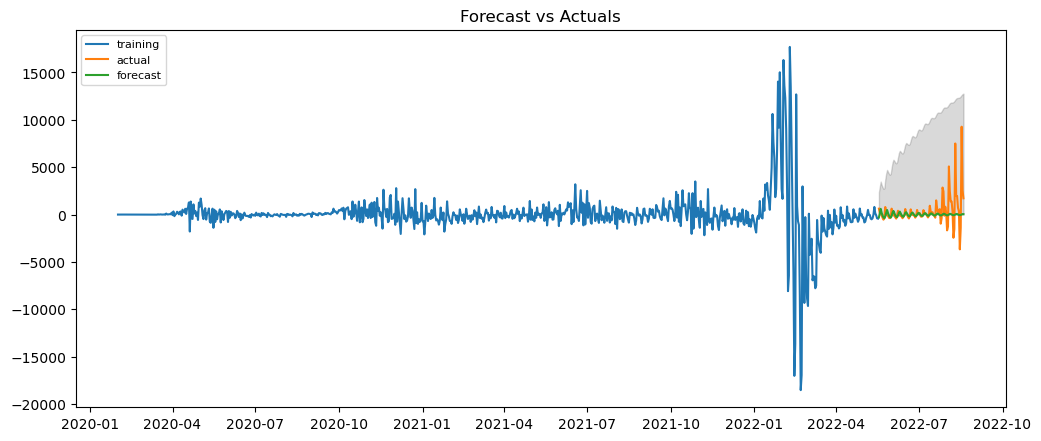

In [56]:
# Create Training and Test
train = series2.dropna()[:int(len(series2)*0.9)] #first 200 rows in the training set
test = series2.dropna()[int(len(series2)*0.9):] #remaining rows in the test set
#If it is not a time series, then this is not the ideal way for #train-test split. You may use scikit-learn library and use function #train_test_split() by providing the ratio. Since this is a time-#series data set, we cannot use future values to predict past #values.
# Build Model
# model = ARIMA(train, order=(0,1,0))  
model = sm.tsa.arima.ARIMA(train, order=(8,1,2))  
fitted = model.fit()

forecast = fitted.get_forecast(len(test))
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)
yhat_conf_int['lower new_cases'] = yhat_conf_int['lower new_cases'].map(lambda x: max(0,x))

# Forecast
fc, se = fitted.forecast(len(test), alpha=0.05).values, fitted.forecast(len(test), alpha=0.05).index  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = yhat_conf_int['lower new_cases']
upper_series = yhat_conf_int['upper new_cases']
lower_series
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [57]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test, fc)

1.5077391130322475

Смертность от ковида

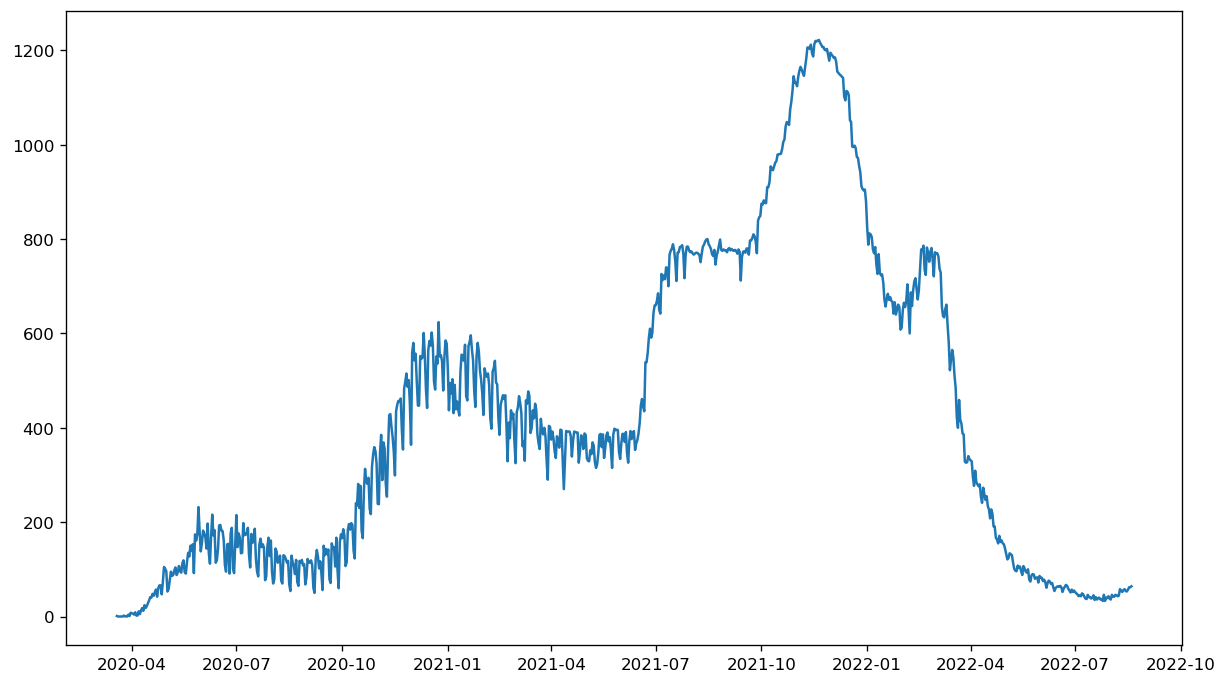

In [58]:
series1_1 = aapl.query('location == "Russia"')['new_deaths'].sort_index()['2020-01':'2022-08']#original series

idx1 = pd.date_range(start="2020-01-31",end="2022-08-19")
series1_1 = pd.Series(index = idx1, data = series1_1)

ax = plt.axes()
# ax.set_facecolor('beige')
plt.plot(series1_1);

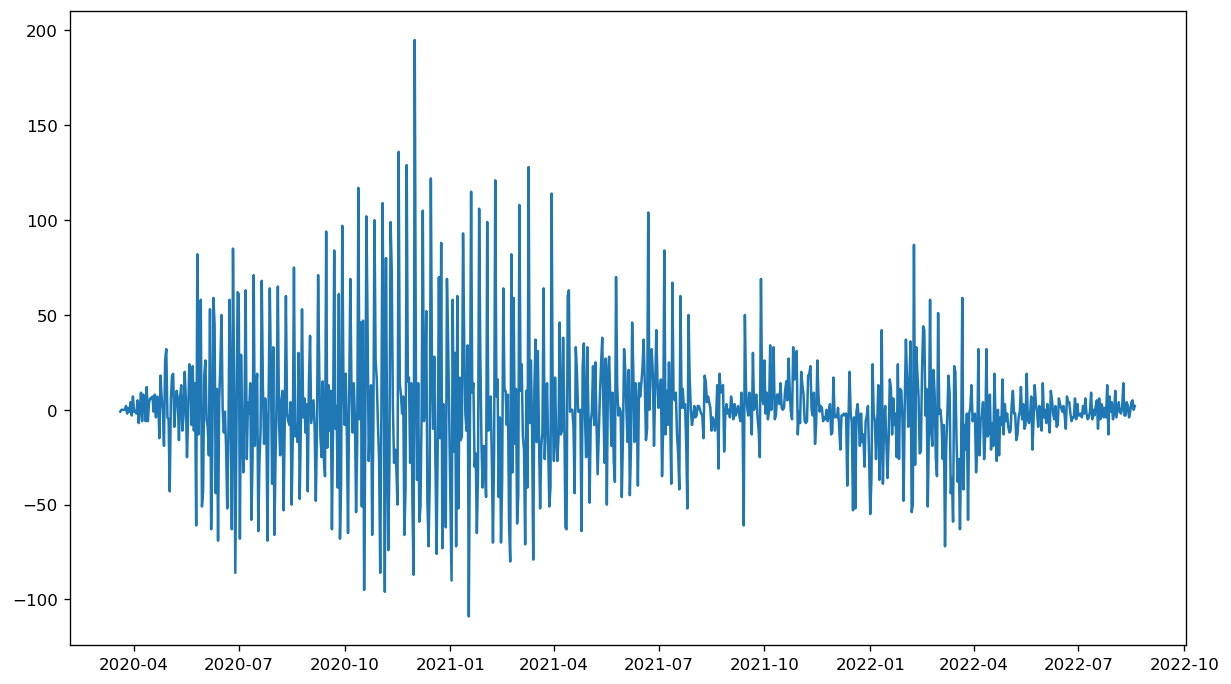

In [59]:
ax = plt.axes()
series2_2 = series1_1.sort_index().diff(1).dropna() #first order differenced series
# ax.set_facecolor('silver')
plt.plot(series2_2);

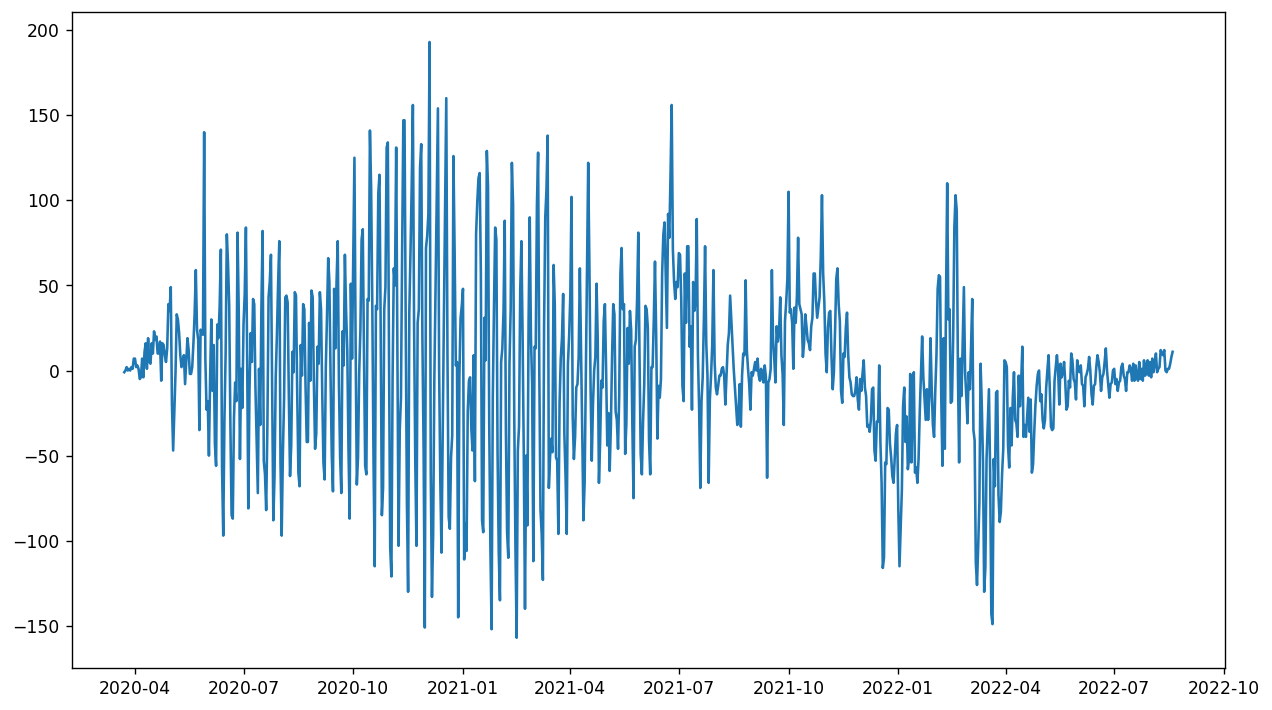

In [84]:
ax = plt.axes()
series2_1 = series1_1.sort_index().diff(4).dropna() #first order differenced series
# ax.set_facecolor('silver')
plt.plot(series2_1);

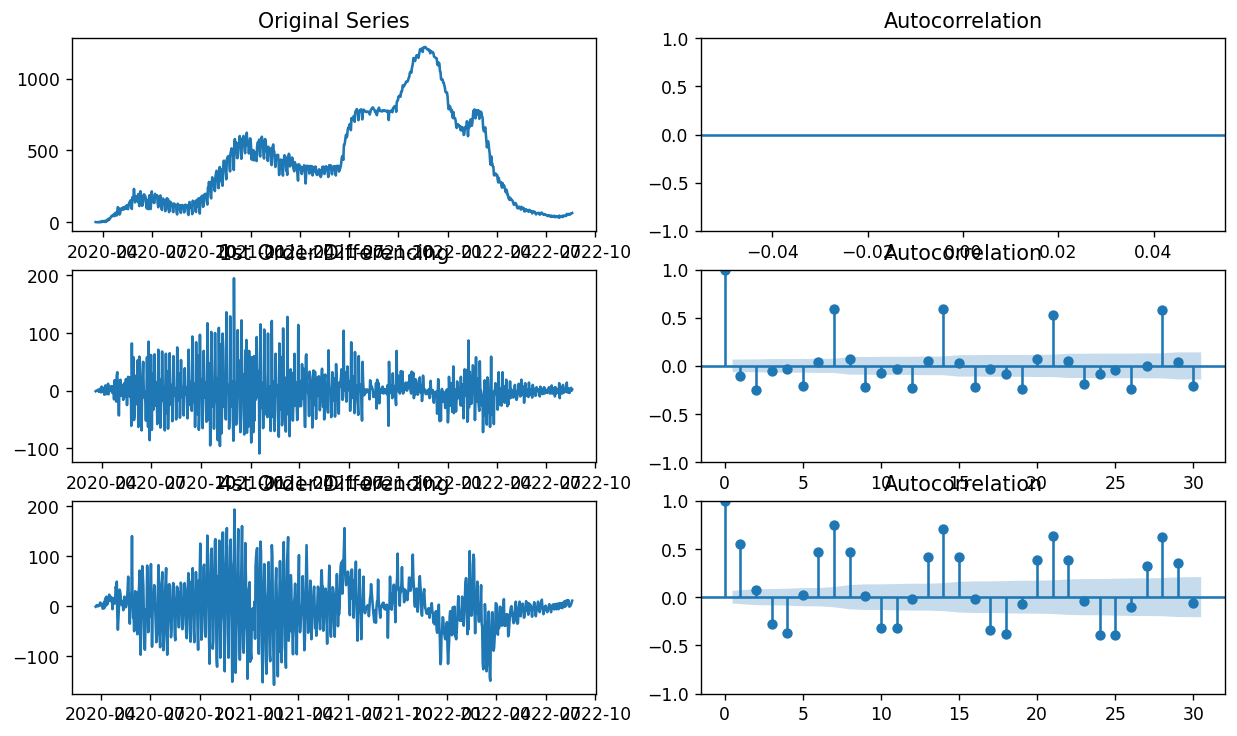

In [85]:
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':124})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(series1_1); 
axes[0, 0].set_title('Original Series')
plot_acf(series1_1, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(series2_2);
axes[1, 0].set_title('1st Order Differencing')
plot_acf(series2_2, ax=axes[1, 1])

# 4st Differencing
axes[2, 0].plot(series2_1);
axes[2, 0].set_title('4st Order Differencing')
plot_acf(series2_1, ax=axes[2, 1])
plt.show()

In [86]:
# Adf Test
ndiffs(series2_2, test='adf') # output is 0
# # KPSS test
ndiffs(series2_2, test='kpss')  # output is 1
# # PP test:
ndiffs(series2_2, test='pp')  # output is 0

0

In [95]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(series2_2, order=(10,1,0)).fit() # гипотеза НЕ отвергается --> нет автокорреляции остатков
sm.stats.acorr_ljungbox(model.resid, lags=[4], return_df=True)

,lb_stat,lb_pvalue
4,1.306503,0.860271


In [93]:
model = pm.auto_arima(series2_2.dropna(), start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9410.386, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9229.917, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9408.386, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9059.698, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8980.966, Time=0.40 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=8968.579, Time=0.50 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=8885.336, Time=0.54 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=8363.518, Time=1.16 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=8216.895, Time=1.31 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=8175.204, Time=1.64 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=8158.737, Time=1.71 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=8152.242, Time=2.28 sec
 ARIMA(10,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.50 sec
 ARIMA(9,1,1)(0,0,0)[0] intercept   : AIC

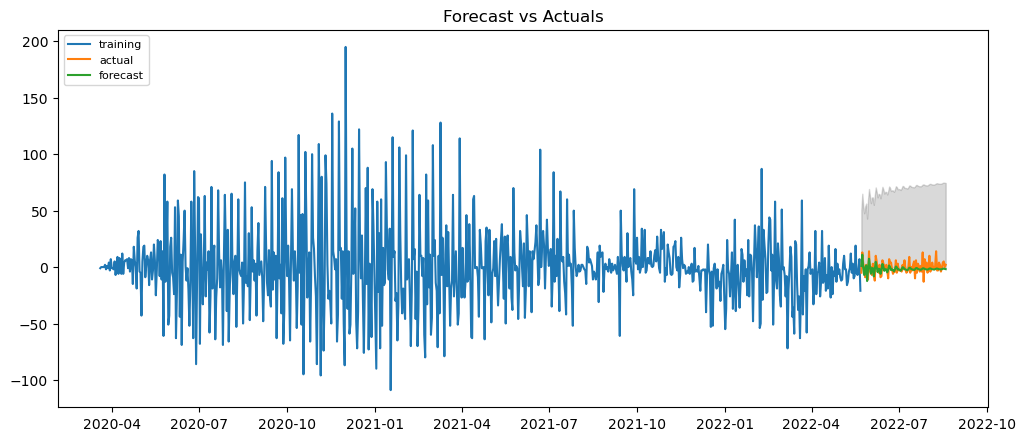

In [96]:
train = series2_2.dropna()[:int(len(series2_2)*0.9)] #first 200 rows in the training set
test = series2_2.dropna()[int(len(series2_2)*0.9):] #remaining rows in the test set
#If it is not a time series, then this is not the ideal way for #train-test split. You may use scikit-learn library and use function #train_test_split() by providing the ratio. Since this is a time-#series data set, we cannot use future values to predict past #values.
# Build Model
# model = ARIMA(train, order=(10,1,0))  
model = sm.tsa.arima.ARIMA(train, order=(10,1,0))  
fitted = model.fit()

forecast = fitted.get_forecast(len(test))
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)
yhat_conf_int['lower new_deaths'] = yhat_conf_int['lower new_deaths'].map(lambda x: max(0,x))

# Forecast
fc, se = fitted.forecast(len(test), alpha=0.05).values, fitted.forecast(len(test), alpha=0.05).index  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = yhat_conf_int['lower new_deaths']
upper_series = yhat_conf_int['upper new_deaths']
lower_series
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Вакцинация

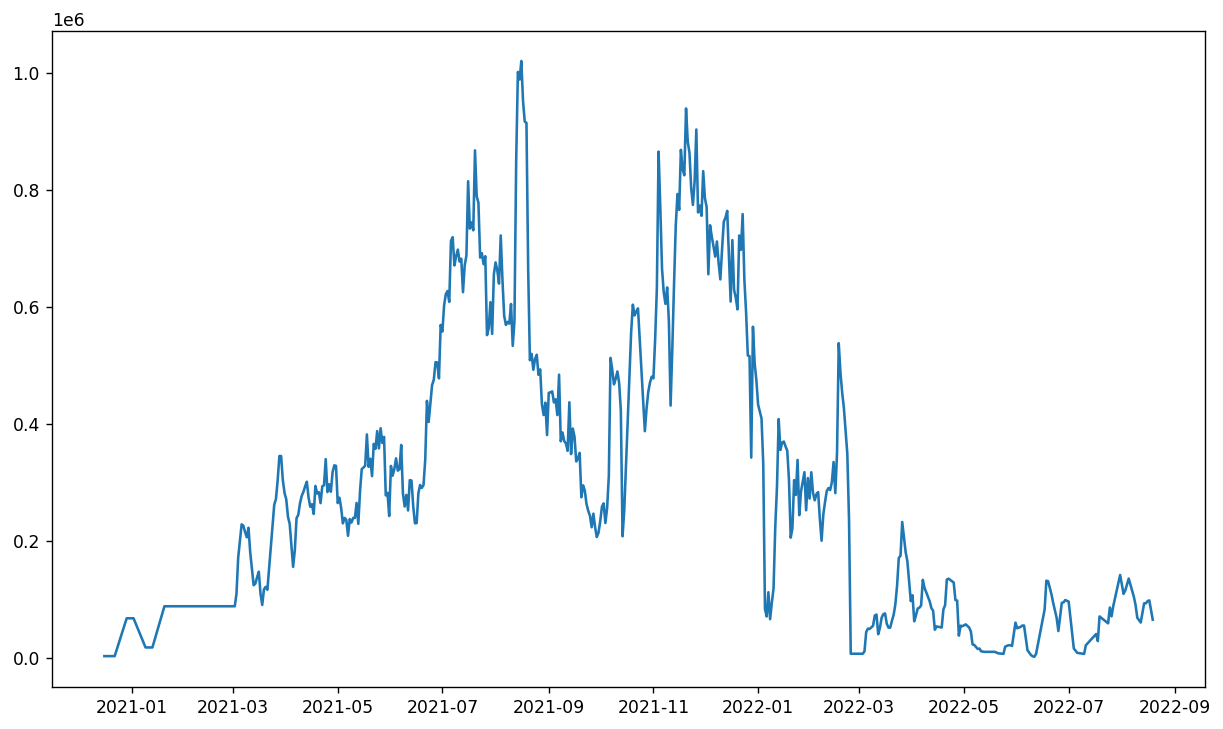

In [118]:
series3 = aapl.query('location == "Russia"')['new_vaccinations_smoothed'].sort_index()['2020-01':'2022-08']#original series

idx3 = pd.date_range(start="2020-01-31",end="2022-08-19")
series3 = pd.Series(index = idx3, data = series3)

ax = plt.axes()
# ax.set_facecolor('beige')
plt.plot(series3);

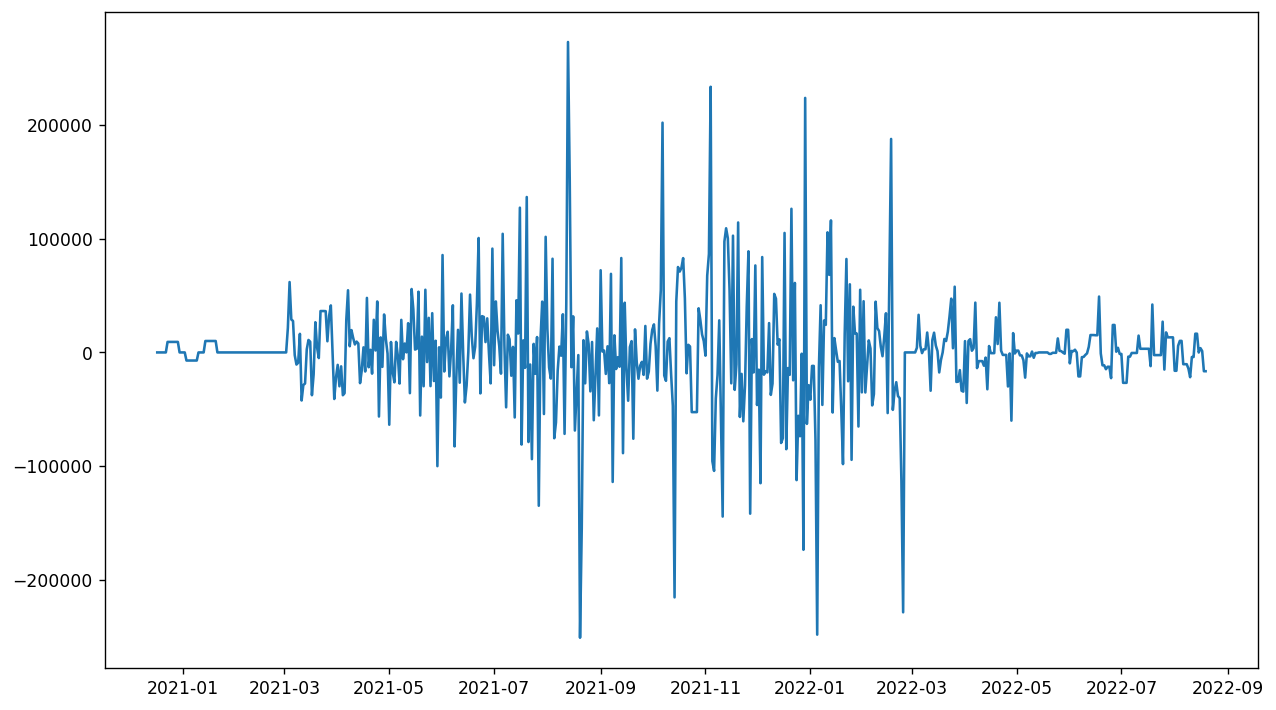

In [119]:
ax = plt.axes()
series3_1 = series3.sort_index().diff(1).dropna() #first order differenced series
# ax.set_facecolor('silver')
plt.plot(series3_1);

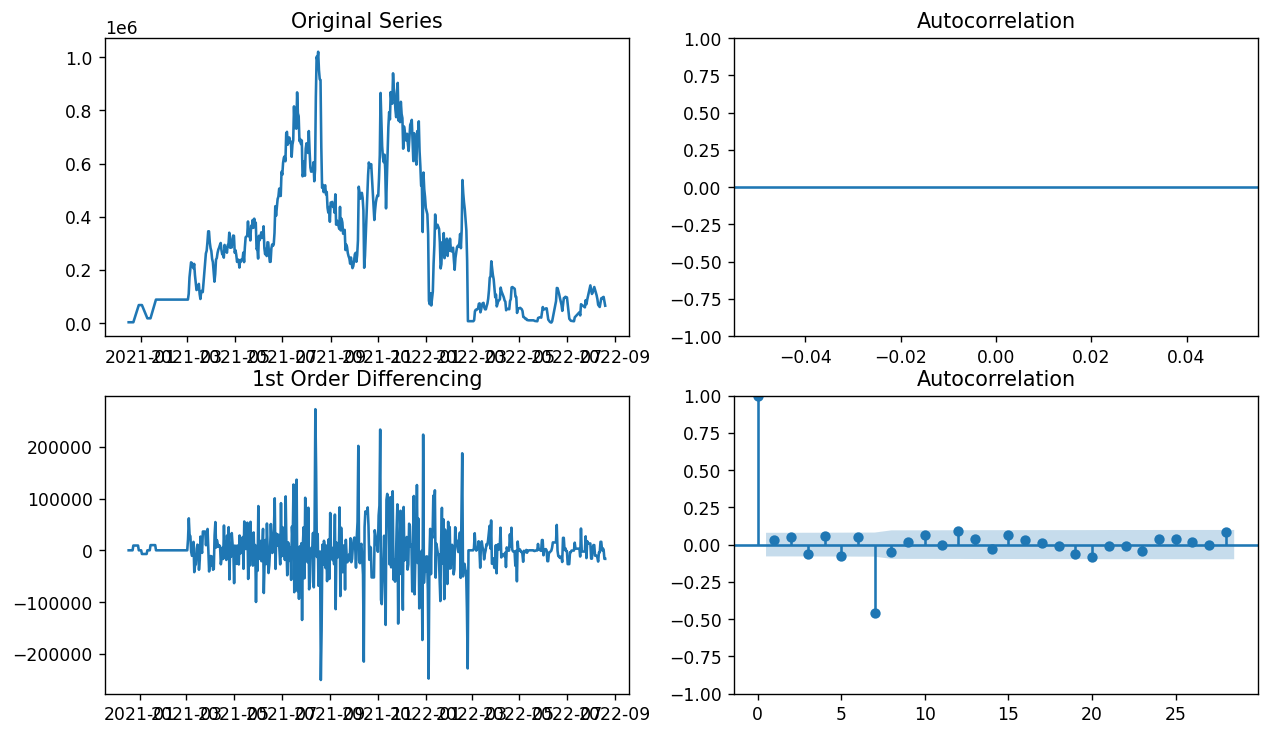

In [121]:
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':124})
# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(series3); 
axes[0, 0].set_title('Original Series')
plot_acf(series3, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(series3_1);
axes[1, 0].set_title('1st Order Differencing')
plot_acf(series3_1, ax=axes[1, 1])
plt.show()

In [123]:
# Adf Test
ndiffs(series3_1, test='adf') # output is 0
# # KPSS test
ndiffs(series3_1, test='kpss')  # output is 1
# # PP test:
ndiffs(series3_1, test='pp')  # output is 0

0

In [126]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(series3_1, order=(9,1,5)).fit() # гипотеза НЕ отвергается --> нет автокорреляции остатков
sm.stats.acorr_ljungbox(model.resid, lags=[4], return_df=True)

,lb_stat,lb_pvalue
4,0.692233,0.952283


In [125]:
model = pm.auto_arima(series3_1.dropna(), start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15284.695, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15101.022, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15282.695, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15061.451, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15005.327, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=14997.987, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=14970.661, Time=0.14 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=14933.022, Time=0.24 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=14895.351, Time=0.42 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=14846.639, Time=0.38 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=14831.450, Time=0.58 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=14814.583, Time=0.58 sec
 ARIMA(10,1,1)(0,0,0)[0] intercept   : AIC=14765.360, Time=1.93 sec
 ARIMA(9,1,1)(0,0,0)[0]

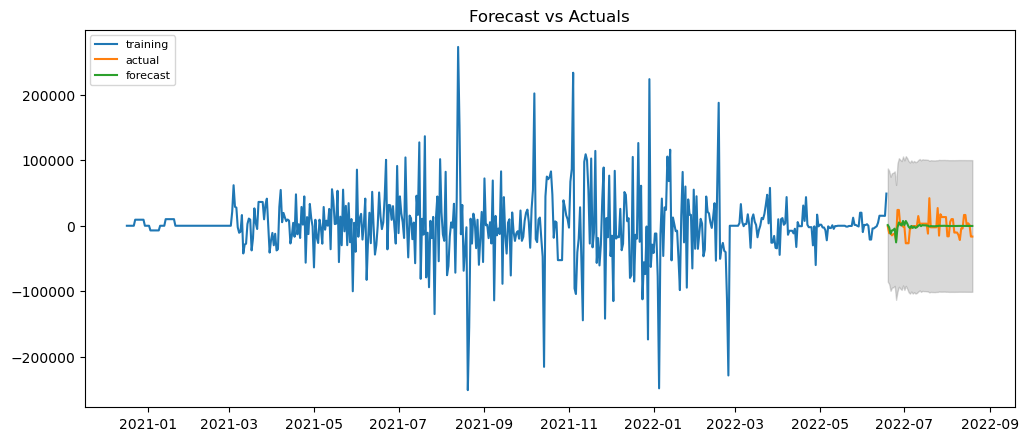

In [127]:
train = series3_1.dropna()[:int(len(series3_1)*0.9)] #first 200 rows in the training set
test = series3_1.dropna()[int(len(series3_1)*0.9):] #remaining rows in the test set
#If it is not a time series, then this is not the ideal way for #train-test split. You may use scikit-learn library and use function #train_test_split() by providing the ratio. Since this is a time-#series data set, we cannot use future values to predict past #values.
# Build Model
# model = ARIMA(train, order=(10,1,0))  
model = sm.tsa.arima.ARIMA(train, order=(9,1,5))  
fitted = model.fit()

forecast = fitted.get_forecast(len(test))
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)
yhat_conf_int['lower new_deaths'] = yhat_conf_int['lower new_vaccinations_smoothed'].map(lambda x: max(0,x))

# Forecast
fc, se = fitted.forecast(len(test), alpha=0.05).values, fitted.forecast(len(test), alpha=0.05).index  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = yhat_conf_int['lower new_vaccinations_smoothed']
upper_series = yhat_conf_int['upper new_vaccinations_smoothed']
lower_series
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Строим VAR

In [128]:
mdata = pd.DataFrame([series2, series2_2, series3_1]).T.dropna()
mdata

,new_cases,new_deaths,new_vaccinations_smoothed
2020-12-17,1713.0,-10.0,0.0
2020-12-18,329.0,28.0,0.0
2020-12-19,-344.0,-28.0,0.0
2020-12-20,738.0,-76.0,0.0
2020-12-21,407.0,-17.0,0.0
...,...,...,...
2022-08-15,-3672.0,-1.0,-64.0
2022-08-16,-1392.0,4.0,3781.0
2022-08-17,9273.0,5.0,1201.0
2022-08-18,2553.0,0.0,-16515.0


In [129]:
from arch.unitroot import engle_granger

res = engle_granger(mdata['new_cases'], mdata['new_deaths'])
# Print the summary
print(res.summary())
# Print the CI vector
print(res.cointegrating_vector)

     Engle-Granger Cointegration Test    
Test Statistic                     -7.034
P-value                             0.000
ADF Lag length                         14
Estimated Root ρ (γ+1)              0.735
-----------------------------------------

Trend: Constant
Critical Values: -3.05 (10%), -3.35 (5%), -3.92 (1%)
Null Hypothesis: No Cointegration
Alternative Hypothesis: Cointegration
Distribution Order: 1
new_cases      1.000000
new_deaths    -2.298547
const        -19.889107
dtype: float64


In [130]:
res = engle_granger(mdata['new_deaths'], mdata['new_cases'])
# Print the summary
print(res.summary())
# Print the CI vector
print(res.cointegrating_vector)

     Engle-Granger Cointegration Test    
Test Statistic                     -3.620
P-value                             0.023
ADF Lag length                         13
Estimated Root ρ (γ+1)              0.490
-----------------------------------------

Trend: Constant
Critical Values: -3.05 (10%), -3.35 (5%), -3.92 (1%)
Null Hypothesis: No Cointegration
Alternative Hypothesis: Cointegration
Distribution Order: 1
new_deaths    1.000000
new_cases    -0.000243
const         0.855419
dtype: float64


In [131]:
res = engle_granger(mdata['new_deaths'], mdata['new_vaccinations_smoothed'])
# Print the summary
print(res.summary())
# Print the CI vector
print(res.cointegrating_vector)

     Engle-Granger Cointegration Test    
Test Statistic                     -3.602
P-value                             0.025
ADF Lag length                         13
Estimated Root ρ (γ+1)              0.493
-----------------------------------------

Trend: Constant
Critical Values: -3.05 (10%), -3.35 (5%), -3.92 (1%)
Null Hypothesis: No Cointegration
Alternative Hypothesis: Cointegration
Distribution Order: 1
new_deaths                   1.000000
new_vaccinations_smoothed   -0.000019
const                        0.852978
dtype: float64


In [132]:
res = engle_granger(mdata['new_cases'], mdata['new_vaccinations_smoothed'])
# Print the summary
print(res.summary())
# Print the CI vector
print(res.cointegrating_vector)

     Engle-Granger Cointegration Test    
Test Statistic                     -7.054
P-value                             0.000
ADF Lag length                         14
Estimated Root ρ (γ+1)              0.733
-----------------------------------------

Trend: Constant
Critical Values: -3.05 (10%), -3.35 (5%), -3.92 (1%)
Null Hypothesis: No Cointegration
Alternative Hypothesis: Cointegration
Distribution Order: 1
new_cases                     1.000000
new_vaccinations_smoothed    -0.002827
const                       -17.645184
dtype: float64


In [135]:
res = engle_granger(mdata['new_vaccinations_smoothed'], mdata['new_cases'])
# Print the summary
print(res.summary())
# Print the CI vector
print(res.cointegrating_vector)

     Engle-Granger Cointegration Test    
Test Statistic                     -8.889
P-value                             0.000
ADF Lag length                         13
Estimated Root ρ (γ+1)             -0.424
-----------------------------------------

Trend: Constant
Critical Values: -3.05 (10%), -3.35 (5%), -3.92 (1%)
Null Hypothesis: No Cointegration
Alternative Hypothesis: Cointegration
Distribution Order: 1
new_vaccinations_smoothed     1.000000
new_cases                    -0.810259
const                       -87.227482
dtype: float64


Нигде нет коинтеграции, это хорошо, потому что можем строить VAR модель :)

In [133]:
#instantiate the VAR fuction on time series data
from statsmodels.tsa.api import VAR

model = VAR(mdata)


for i in ['aic', 'bic', 'hqic']:
    #maxlags takes the number of lags we want to test
    #ic takes the information criterion metod based on which order would be suggested
    results = model.fit(maxlags=6, ic=i)
    order = results.k_ar
    print(f"The suggested VAR order from {i} is {order}")

# # Для оценки VAR
# ##Fit VAR model as suggested by VAR select information criterion
# #instantiate the VAR fuction on time series data
model = VAR(mdata)
model_fit = model.fit(maxlags = 6, ic = 'aic')
model_fit.summary()

##Collect coefficient values
# model_fit.params
# #Random Shock deviation
# model_fit.sigma_u
# # # проверка автокор в остатках
# # #To test absence of significant residual autocorrelations one can use the test_whiteness method of VARResults
# test_corr = model_fit.test_whiteness(nlags=4, signif=0.05, adjusted=False)

# ##Print the p-value
# ##There is no serial autocorrelation in residuals if p-value is more than 0.05
# test_corr.pvalue # 1.0228013921736956e-13 -- есть автокорреляция --> идем плакать :( --> идем подделывать данные 0.004092349368580301


# # #Check for VAR Stability
# # #Check if Var model is stable
# stest = model_fit.is_stable() #True
# stest

# # ### Result of stest is TRUE, hence Python suggests the model is stable

test1 = model_fit.test_causality('new_cases', causing=['new_deaths'], kind='wald', signif=0.05)
test1.pvalue


# test2 = model_fit.test_causality('new_deaths', causing=['new_cases'], kind='wald', signif=0.05)
# test2.pvalue


The suggested VAR order from aic is 6
The suggested VAR order from bic is 6
The suggested VAR order from hqic is 6


2.227780043391829e-05

<Figure size 1240x1240 with 0 Axes>

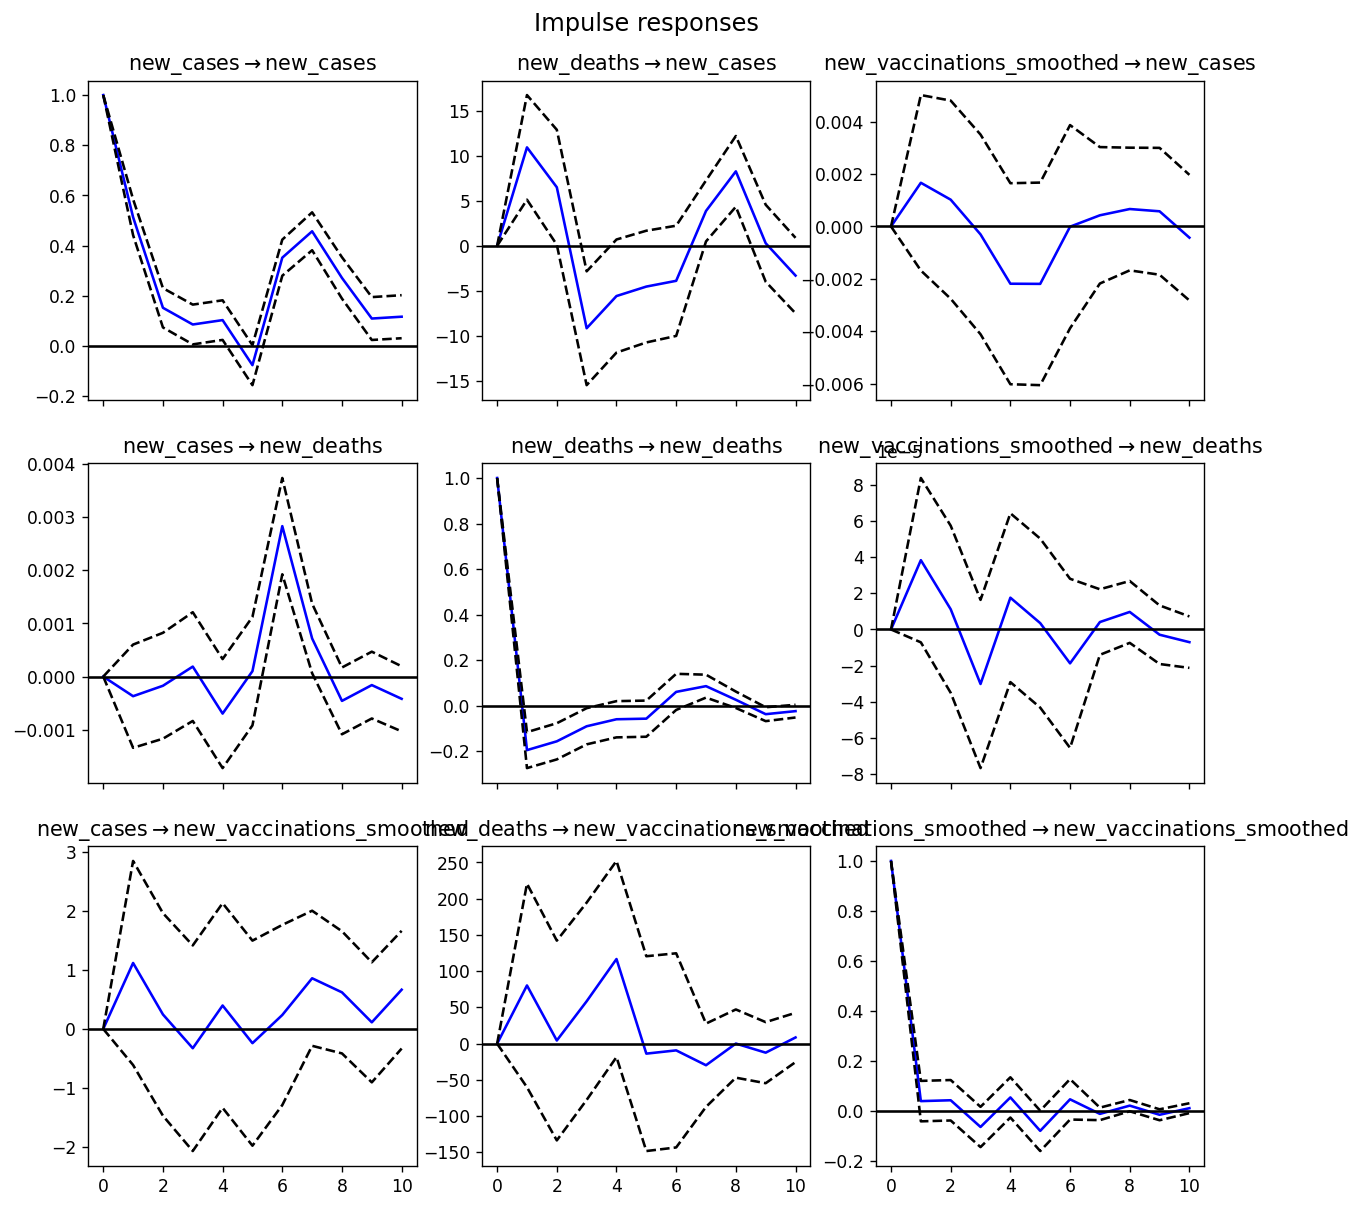

In [134]:
irf = model_fit.irf(10)
fig = plt.figure(figsize = (10,10))
# ax = fig.add_subplot(111)

ax = irf.plot(orth=False);

In [136]:
fevd = model_fit.fevd(5)
fevd.summary()

FEVD for new_cases
     new_cases  new_deaths  new_vaccinations_smoothed
0     1.000000    0.000000                   0.000000
1     0.981124    0.017608                   0.001268
2     0.975006    0.023289                   0.001705
3     0.963788    0.034498                   0.001714
4     0.957791    0.038464                   0.003745

FEVD for new_deaths
     new_cases  new_deaths  new_vaccinations_smoothed
0     0.004357    0.995643                   0.000000
1     0.004384    0.991154                   0.004462
2     0.004288    0.990983                   0.004729
3     0.004614    0.988041                   0.007345
4     0.006655    0.985145                   0.008200

FEVD for new_vaccinations_smoothed
     new_cases  new_deaths  new_vaccinations_smoothed
0     0.000017    0.001866                   0.998117
1     0.001860    0.004031                   0.994108
2     0.001952    0.004042                   0.994006
3     0.002177    0.004913                   0.992910
4     

<Figure size 1240x1240 with 0 Axes>

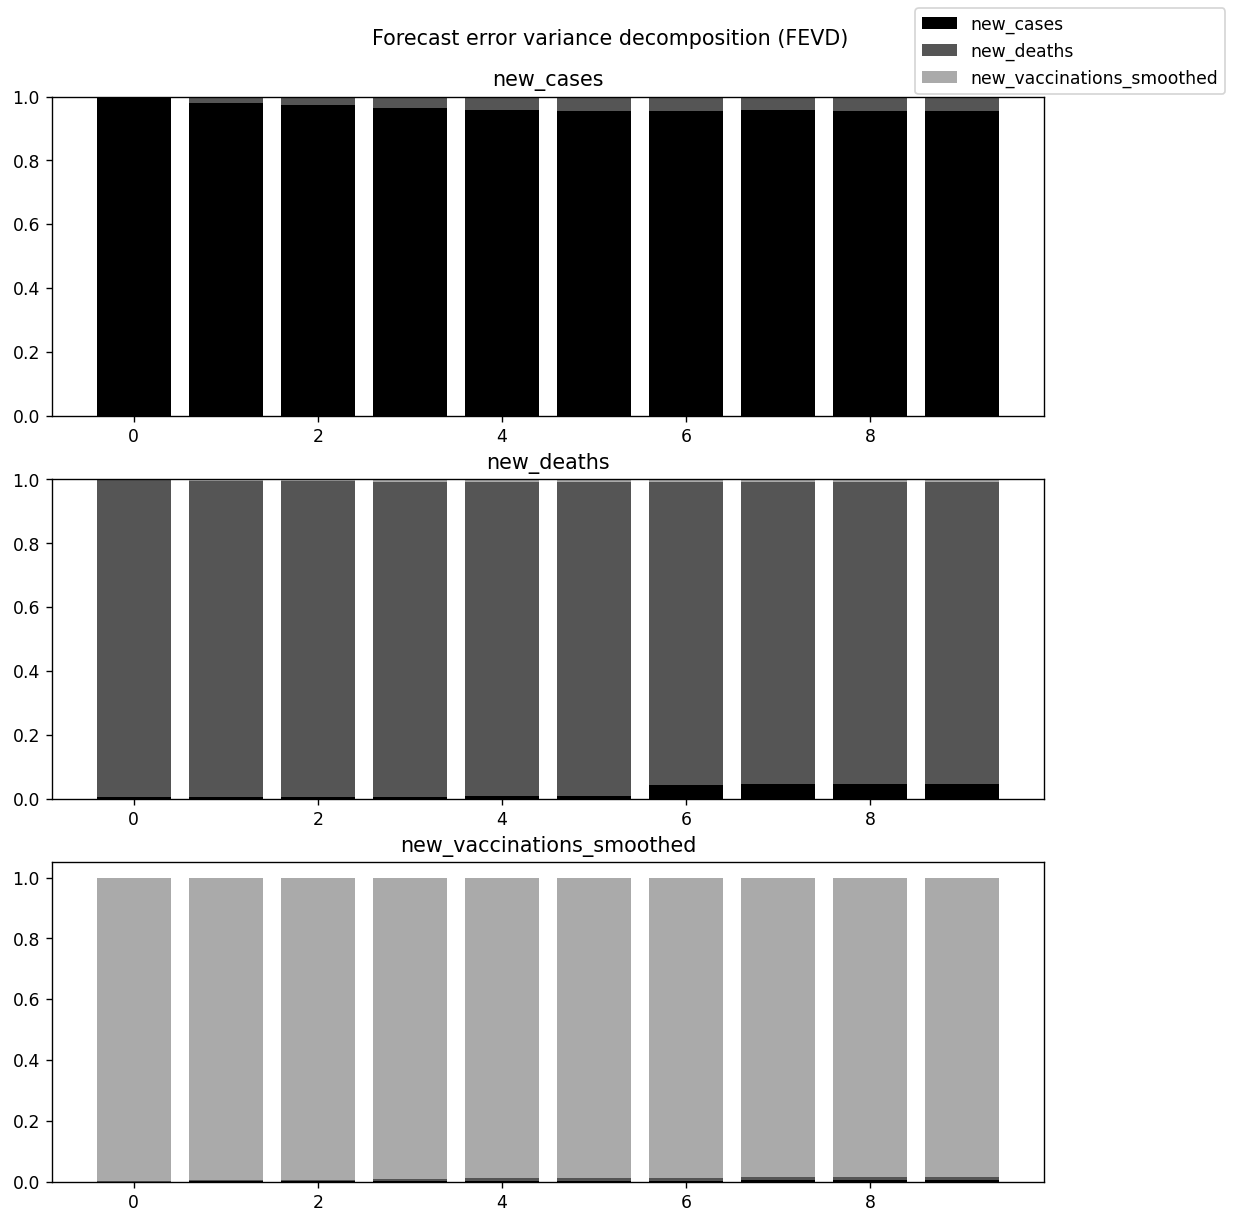

In [137]:
fig = plt.figure(figsize = (10,10))
ax = model_fit.fevd(10).plot()

Просто проверка на сезонность 

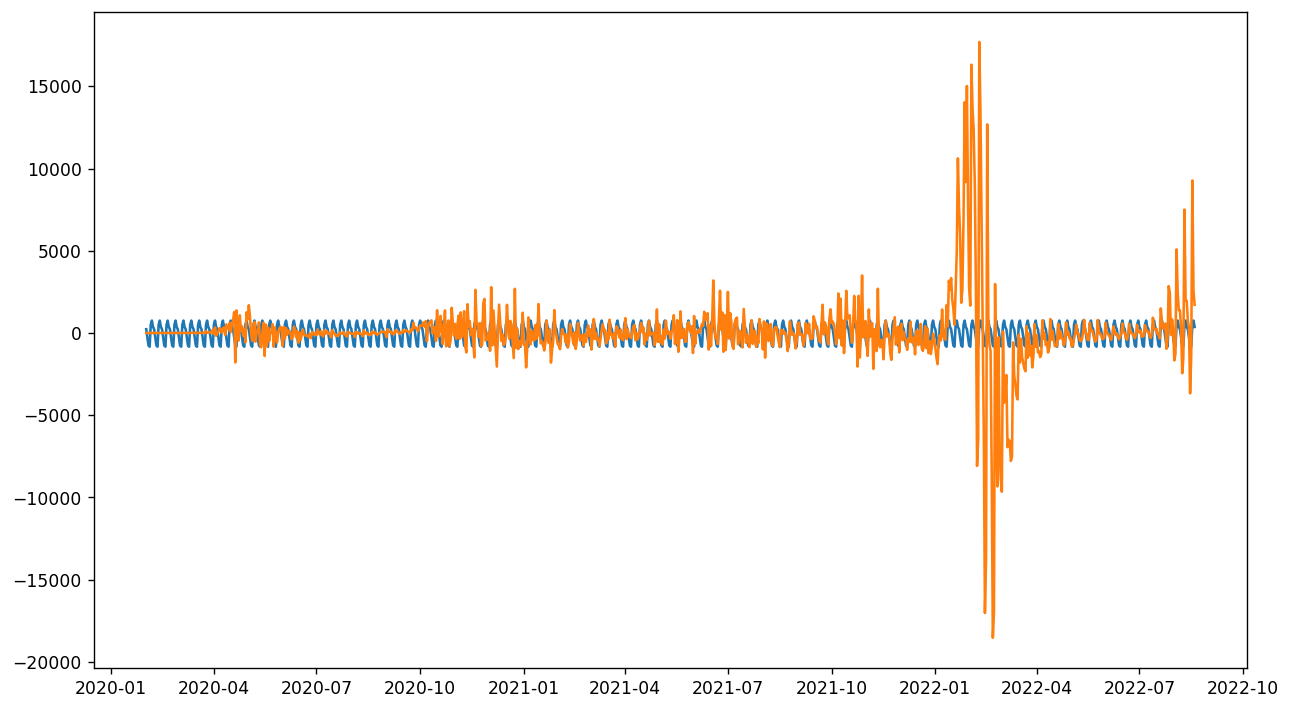

In [113]:
from statsmodels.tsa import seasonal
plt.plot(seasonal.seasonal_decompose(series2).seasonal)
plt.plot(series2);

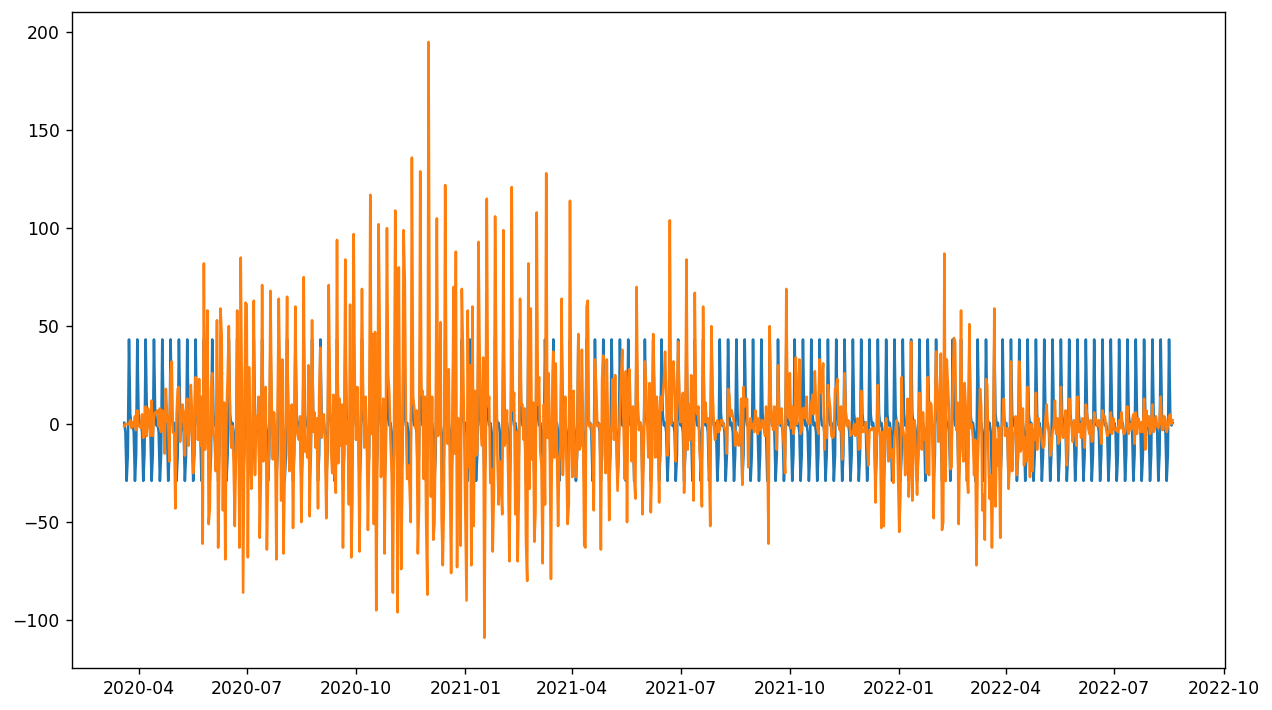

In [114]:
from statsmodels.tsa import seasonal
plt.plot(seasonal.seasonal_decompose(series2_2).seasonal)
plt.plot(series2_2);